For getting RA/Dec from x,y,z accelermoter values:  
http://www.instructables.com/id/Accelerometer-Gyro-Tutorial/?ALLSTEPS

For generating a plot of those RA/Dec values:  
http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html

In [13]:
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, cache=True))

In [14]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

%matplotlib inline
import matplotlib.pyplot as plt
import ephem # to make coordinate systems conversions

Here is a sensor reading that we are going to try and emulate. The RA/Dec as given by the mount is below

```
{
        "_id" : ObjectId("549c7c39a1cc1400b84857e4"),
        "data" : {
                "/dev/arduino_0" : {
                        "humidity" : 18.6,
                        "count" : 1328843835,
                        "temp_02" : 23.56,
                        "temp_00" : 22.8,
                        "voltages" : {
                                "ac" : 5,
                                "dc" : 12.75
                        },
                        "temp_01" : 24.5,
                        "fan" : 1,
                        "temp_03" : 27
                },
                "/dev/arduino_1" : {
                        "accelerometer" : {
                                "o" : 7,
                                "z" : 0,
                                "y" : -0.02,
                                "x" : -0.99
                        },
                        "humidity" : 99.9,
                        "count" : 1324468826,
                        "temp_01" : 16.8
                }
        },
        "date" : ISODate("2015-07-15T04:01:54.163Z"),
        "status" : "current",
        "type" : "environment"
}
```  

```
<SkyCoord (ICRS): (ra, dec) in deg 
    (16.84008333, -16.55122222)>

```

MLO Stats:
http://www.esrl.noaa.gov/gmd/obop/mlo/aboutus/siteInformation/mlosite.html

In [5]:
x = -0.99
y = -0.02
z = 0.

mlo_lat = 19.54 * u.deg
mlo_long = -155.58 * u.deg
mlo_height = 3397 * u.m

mlo = EarthLocation(lat=mlo_lat, lon=mlo_long, height=mlo_height)
utc_offset = -10 * u.hour

time = Time('2015-07-15 04:01:54.163') - utc_offset

In [43]:
def position_1(x, y, z, long, lat):
    """ Calculate the HA/Dec from accelerometer values """
    R_x = x
    R_y = y
    R_z = z

    # Compute the direction vector
    R = np.sqrt(R_x**2 + R_y**2 + R_z**2)

    # Get the angles
    A_xr = np.arccos(R_x / R) * u.radian
    A_yr = np.arccos(R_y / R) * u.radian
    A_zr = np.arccos(R_z / R) * u.radian
    
    alt = -A_zr
    az = 90 * u.deg - A_xr
    
    dec = np.arcsin( 
        np.sin(alt) * np.sin(lat) + 
        np.cos(lat) * np.cos(long) * np.cos(az) 
    )
    
    ha = np.arccos(
        np.cos(long) * (1/np.cos(dec)) - 
        np.tan(dec) * np.tan(long)
    )
    
    return (ha, dec)
    
    """
    ha_1 = (90 * u.deg) + np.arccos(A_yr.to(u.deg)/long)
    ha_2 = (90 * u.deg) - np.arccos(A_yr.to(u.deg)/long)
    print(ha_1, ha_2)
    
    d_y1 = (A_xr.to(u.deg) * np.sin(long)) - (A_zr.to(u.deg) * np.cos(long) * np.cos(ha_1))
    d_y2 = (A_xr.to(u.deg) * np.sin(long)) - (A_zr.to(u.deg) * np.cos(long) * np.cos(ha_2))
    print(d_y1, d_y2)
    
    coords2 = coord.SkyCoord(ra=ha_1, dec=d_y2)    
    
    print(coords2.ra.to(u.hourangle))
    print(coords2.dec)
    
    return coords2
    """

In [52]:
ha, dec = position_1(x,y,z,mlo_long, mlo_lat)

In [55]:
ha.to(u.hourangle)

<Quantity 9.555286613117243 hourangle>

In [54]:
dec.to(u.deg)

<Quantity -20.59724748349843 deg>

In [34]:
coords.location = mlo

In [38]:
coords.ra.to(u.hourangle)

<Longitude 14.391197648490559 hourangle>

In [37]:
altaz = coords.transform_to(AltAz(obstime=time,location=mlo))  
altaz

<SkyCoord (AltAz: obstime=2015-07-15 14:01:54.163, location=(-5478043.662679353, -2487256.852071931, 2120911.9170668446) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron):01:54.163, location=(-5478043.662679353, -2487256.852071931, 2120911.9170668446) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    (277.48832646, -41.94480764)>

In [62]:
def plot_mwd(RA,Dec,org=0,title='Mollweide projection', projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    x[x > 180] -= 360                # scale conversion to [-180, 180]
    x=-x                             # reverse the scale: East to the left
    
    # Setup the figure
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection, axisbg ='LightCyan')
    
    # Generate the scatter plot
    ax.scatter(np.radians(x),np.radians(Dec))  # convert degrees to radians
    
    # Setup longitude lines
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    ax.set_xticklabels(tick_labels)

    ax.set_title(title)
    ax.title.set_fontsize(15)

    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    
    ax.grid(True)

In [16]:
ra = np.array([x.ra.degree])
dec = np.array([x.dec.degree])

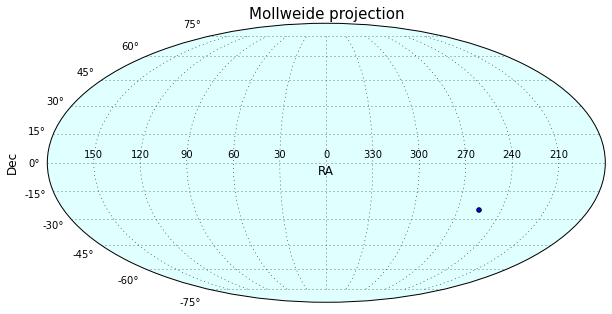

In [17]:
plot_mwd(ra,dec)